# TS-RAPOOC

### Based on RAPOOC algorithm proposed by Omar Odibat (2014)

- Step 1: Divide rows into two separate parts
- Step 2: Decide which part will be devided among all generated clusters
- Step 3: Divide the chosen cluster in columns or rows, the one that has the highest coherence
- Step 4: Check the number of clusters generated this way, if the number of clusters is reached, break, else return to step 2

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing
from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler

from metrics import *
from clusterer import *

In [7]:
PATH = 'TestData/SimulatedDataCoherence/'

In [10]:
data = pd.read_csv(f'{PATH}BiclusterABC_high.csv',header=None)

/home/a20125359/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


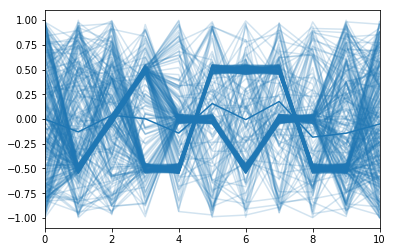

In [11]:
sns.tsplot(np.array(data), err_style="unit_traces")

In [12]:
class ClusterMaps(object):
    def __init__(self, rho=None, gamma=None, H = 0):
        self.gamma = gamma
        self.rho = rho
        self.H = H
    
    def __str__(self):
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))

In [16]:
class TsRapooc(object):
    def __init__(self, data, n_clusters = 5):
        self._D = np.array(data)
        self._n_clusters = n_clusters
        self._labels = list()
        self._I, self._J = data.shape
        self._cluster_count = 0
        
    @property
    def n_clusters(self):
        return self._n_clusters
    
    @property
    def data(self):
        return self._D
    
    @property
    def labels(self):
        return _labels
    
    def fit(self):
        n_iteration = 0
        n_clusters = 0
        for n_iteration in range(0, self._n_clusters-1):
            if n_iteration == 0:
                try:
                    initial_partition = BisectingClusterer(self._D).fit_rows()
                    self._labels.append(ClusterMaps(np.where(initial_partition==0)[0],
                                        np.arange(self._J),
                                        PairBasedCoherence(self._D[np.where(initial_partition==0)]).HP))

                    self._labels.append(ClusterMaps(np.where(initial_partition==1)[0],
                                       np.arange(self._J),
                                       PairBasedCoherence(self._D[np.where(initial_partition==1)]).HP))
                except IndexError:
                    print("Index error")
                    print("partition 0")
                    print(np.where(initial_partition==0))
                    print("partition 1")
                    print(np.where(initial_partition==1))
            else:
                self._partition()
            # print(n_iteration+1)
        
    def _partition(self):
        least_coherent, least_coherent_index = self._find_least_coherent()
        lowest_cluster = self._D[np.ix_(least_coherent.rho,least_coherent.gamma)]
        self._bisect_bicluster(lowest_cluster, least_coherent,least_coherent_index)
    
    def _find_least_coherent(self):
        
        return self._labels[self._labels.index(min(filter(lambda cluster: len(cluster.gamma)>2 and len(cluster.rho)>2 ,self._labels),key=attrgetter('H')))], self._labels.index(min(self._labels,key=attrgetter('H')))
    
    def _bisect_bicluster(self,cluster, cluster_node, node_index):
        #which of the biclusters maximize coherence
        rows_map = BisectingClusterer(cluster).fit_rows()
        cols_map = BisectingClusterer(cluster).fit_cols()
        
        flg_alls= 'none'
        
        if(np.all(cols_map) or np.all(rows_map)):
            # if all rows are in the same bicluster, then divide columns
            if(np.all(rows_map)):
                print(rows_map)
                flg_alls = 'cols'
            else:
                print(cols_map)
                flg_alls = 'rows'
        # print('\n'+flg_alls +" labels "+ str(node_index))
        if(flg_alls == 'none'):
            # find the coherences, the ones which raises the average coherences are the ones that are divided
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            avg_cols = (cols_coherence_1 + cols_coherence_2)/2.0
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            avg_rows = (rows_coherence_1 + rows_coherence_2)/2.0
            if (avg_cols>avg_rows):
                # print('cols division')
                col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], cols_coherence_1)
                self._labels[node_index] = col_cluster_1
                col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], cols_coherence_2)
                self._labels.append(col_cluster_2)
            else:
                # print('rows division')
                row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
                self._labels[node_index] = row_cluster_1
                row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
                self._labels.append(row_cluster_2)
        elif (flg_alls == 'cols'):
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], cols_coherence_1)
            self._labels[node_index] = col_cluster_1
            col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], cols_coherence_2)
            self._labels.append(col_cluster_2)
        else:
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
            self._labels[node_index] = row_cluster_1
            row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
            self._labels.append(row_cluster_2)
            
            

In [ ]:
%%time
tsrapooc = TsRapooc(np.array(data)[:300],10)
tsrapooc.fit()

In [ ]:
print(tsrapooc._labels[2])

0.924757513411 i 0



/home/a20125359/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


0.922040062457 i 1

0.920128805956 i 2

0.937818806466 i 3

0.932789085797 i 4

3


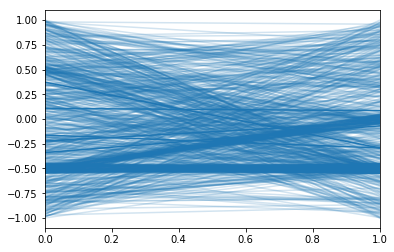

In [19]:
i = 0
max_coherence = 0
cluster = 0
for bicluster in tsrapooc._labels:
    print(str(bicluster.H) +" i "+ str(i)+"\n")
    if (bicluster.H > max_coherence):
        cluster = i
        max_coherence=bicluster.H
    sns.tsplot(data= tsrapooc._D[np.ix_(tsrapooc._labels[i].rho,tsrapooc._labels[i].gamma)],err_style="unit_traces")
    i+=1
    
print(cluster)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


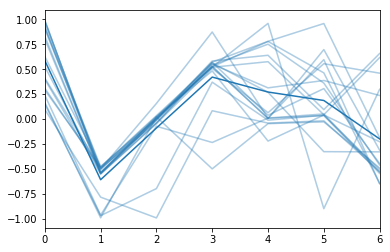

In [557]:
sns.tsplot(data= tsrapooc._D[np.ix_(tsrapooc._labels[16].rho,tsrapooc._labels[16].gamma)],err_style="unit_traces")

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


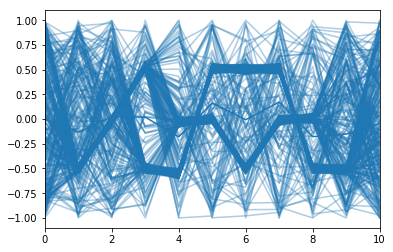

In [543]:
sns.tsplot(data= np.array(data),err_style="unit_traces")

# Sci-kit learn datasets

In [478]:

test_data, rows, columns = make_biclusters(
    shape=(100, 7), n_clusters=5, noise=5,
    shuffle=False, random_state=0)

scaler = MinMaxScaler()
scaler.fit(test_data)
test_data = scaler.transform(test_data)*2-1

test_data, row_idx, col_idx = sg._shuffle(test_data, random_state=0)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


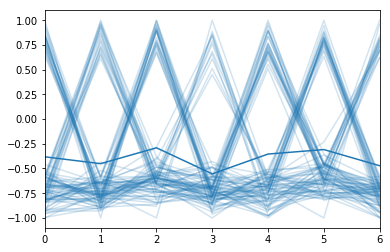

In [479]:
ax = sns.tsplot(data=np.array(test_data), err_style="unit_traces")

In [480]:
tsrapooc_test = TsRapooc(test_data,5)

In [481]:
tsrapooc_test.fit()